In [68]:
#importing all the necessary libraries
from tensorflow.keras import Sequential,datasets
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,Dropout,Activation,BatchNormalization
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import numpy as np
from pylab import rcParams
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
import seaborn as sns

In [2]:
from keras.optimizers import Adam

## Unpickling the dataset

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [4]:
trainData = unpickle('train')

In [5]:
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [6]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


In [8]:
testData = unpickle('test')
metaData = unpickle('meta')

In [9]:
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
category

,SuperClass
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


In [10]:
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])

In [11]:
X_train = trainData['data']

In [12]:
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)

Image number selected : 35562
Image category name: Household_electrical_devices
Image subcategory name: Television


C:\Users\deyah\AppData\Local\Temp\ipykernel_11588\2233737020.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
C:\Users\deyah\AppData\Local\Temp\ipykernel_11588\2233737020.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))


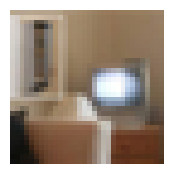

In [21]:
rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))

print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))


In [22]:
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [23]:
y_train = trainData['fine_labels']
y_test = testData['fine_labels']

In [25]:
num_class = 100
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [26]:
#Normalizing
X_train = X_train / 255.
X_test = X_test / 255.

In [28]:
model = Sequential()

#Stack 1
#convolution
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPooling2D(pool_size=2, strides=2))
#dropout 
model.add(Dropout(0.2))

#Stack 2
#convolution
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPooling2D(pool_size=2, strides=2))
#dropout 
model.add(Dropout(0.5))

#Stack 3
#convolution
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPooling2D(pool_size=2, strides=2))
#dropout 
model.add(Dropout(0.5))

#flattening
model.add(Flatten())

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout 
model.add(Dropout(0.5))

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout 
model.add(Dropout(0.5))

#output layer
model.add(Dense(units=100, activation="softmax"))


In [29]:
epochs = 100
batch_size = 64

In [32]:
optimizer =Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


In [34]:
data_gen = ImageDataGenerator(
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            featurewise_center=True,
            width_shift_range=0.1,
            validation_split=0.2)

data_gen.fit(X_train, seed=123)

In [35]:
train_data_gen = data_gen.flow(X_train, y_train, 
                               batch_size=batch_size, 
                               subset="training", seed=123)

valid_data_gen = data_gen.flow(X_train, y_train, 
                               batch_size=batch_size, 
                               subset="validation", seed=123)

In [37]:
# model1.fit(X_train,y_train,epochs=75,validation_data=(X_val, y_val))
model_history = model.fit(train_data_gen,
                          steps_per_epoch=40000//batch_size,
                          validation_data=valid_data_gen,
                          validation_steps=10000//batch_size,
                          callbacks=[early_stop, model_checkpoint],
                          verbose=1,
                          epochs=epochs)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 4.5113 - accuracy: 0.0165
Epoch 1: val_loss improved from inf to 4.37690, saving model to best_model.h5
625/625 [==============================] - 48s 76ms/step - loss: 4.5113 - accuracy: 0.0165 - val_loss: 4.3769 - val_accuracy: 0.0224
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 4.2571 - accuracy: 0.0379
Epoch 2: val_loss improved from 4.37690 to 3.98497, saving model to best_model.h5
625/625 [==============================] - 47s 76ms/step - loss: 4.2571 - accuracy: 0.0379 - val_loss: 3.9850 - val_accuracy: 0.0753
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 3.9428 - accuracy: 0.0799
Epoch 3: val_loss improved from 3.98497 to 3.66883, saving model to best_model.h5
625/625 [==============================] - 47s 76ms/step - loss: 3.9428 - accuracy: 0.0799 - val_loss: 3.6688 - val_accuracy: 0.1287
Epoch 4/100
625/625 [==============================] - ETA: 0s - los

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       590080    
                                                      

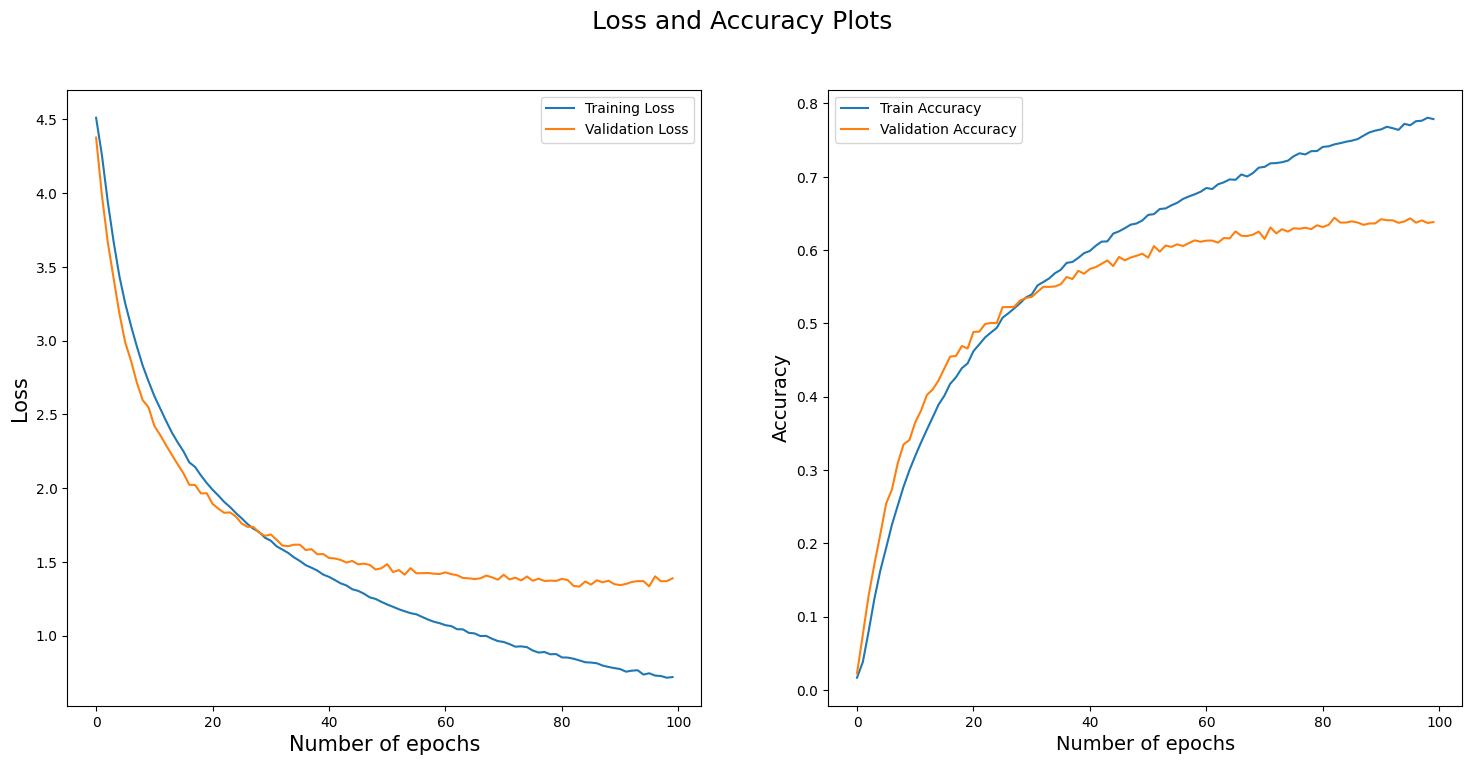

In [42]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [50]:
valid_loss, valid_accuracy = model.evaluate(valid_data_gen, steps=10000//batch_size)
test_loss, test_accuracy = model.evaluate(data_gen.flow(X_test, y_test, seed=123), steps=len(X_test)//batch_size)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")
print(" ")
print('Validation Loss: ', round(valid_loss, 2))
print('Test Loss: ', round(test_loss, 2))

156/156 [==============================] - 4s 23ms/step - loss: 1.3848 - accuracy: 0.6384
Validation Accuracy:  63.82 %
Test Accuracy:  63.84 %
 
Validation Loss:  1.38
Test Loss:  1.38


In [54]:
target = ["Category {}".format(i) for i in range(num_class)]
y_pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target))

313/313 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

  Category 0       0.89      0.71      0.79       100
  Category 1       0.66      0.73      0.69       100
  Category 2       0.41      0.42      0.42       100
  Category 3       0.52      0.16      0.24       100
  Category 4       0.52      0.13      0.21       100
  Category 5       0.36      0.51      0.42       100
  Category 6       0.57      0.59      0.58       100
  Category 7       0.63      0.41      0.50       100
  Category 8       0.72      0.76      0.74       100
  Category 9       0.71      0.65      0.68       100
 Category 10       0.62      0.31      0.41       100
 Category 11       0.48      0.24      0.32       100
 Category 12       0.68      0.51      0.58       100
 Category 13       0.63      0.56      0.59       100
 Category 14       0.57      0.44      0.50       100
 Category 15       0.50      0.56      0.53       100
 Category 16       0.59  

In [55]:
prediction = np.argmax(y_pred, axis=1)
prediction = pd.DataFrame(prediction)

True Label: Couch
Predicted Label: Couch


C:\Users\deyah\AppData\Local\Temp\ipykernel_11588\3544465367.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))


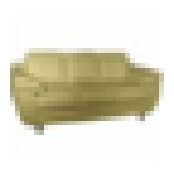

In [66]:
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(subCategory.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

C:\Users\deyah\AppData\Local\Temp\ipykernel_11588\218740250.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize()
C:\Users\deyah\AppData\Local\Temp\ipykernel_11588\218740250.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize()
C:\Users\deyah\AppData\Local\Temp\ipykernel_11588\218740250.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

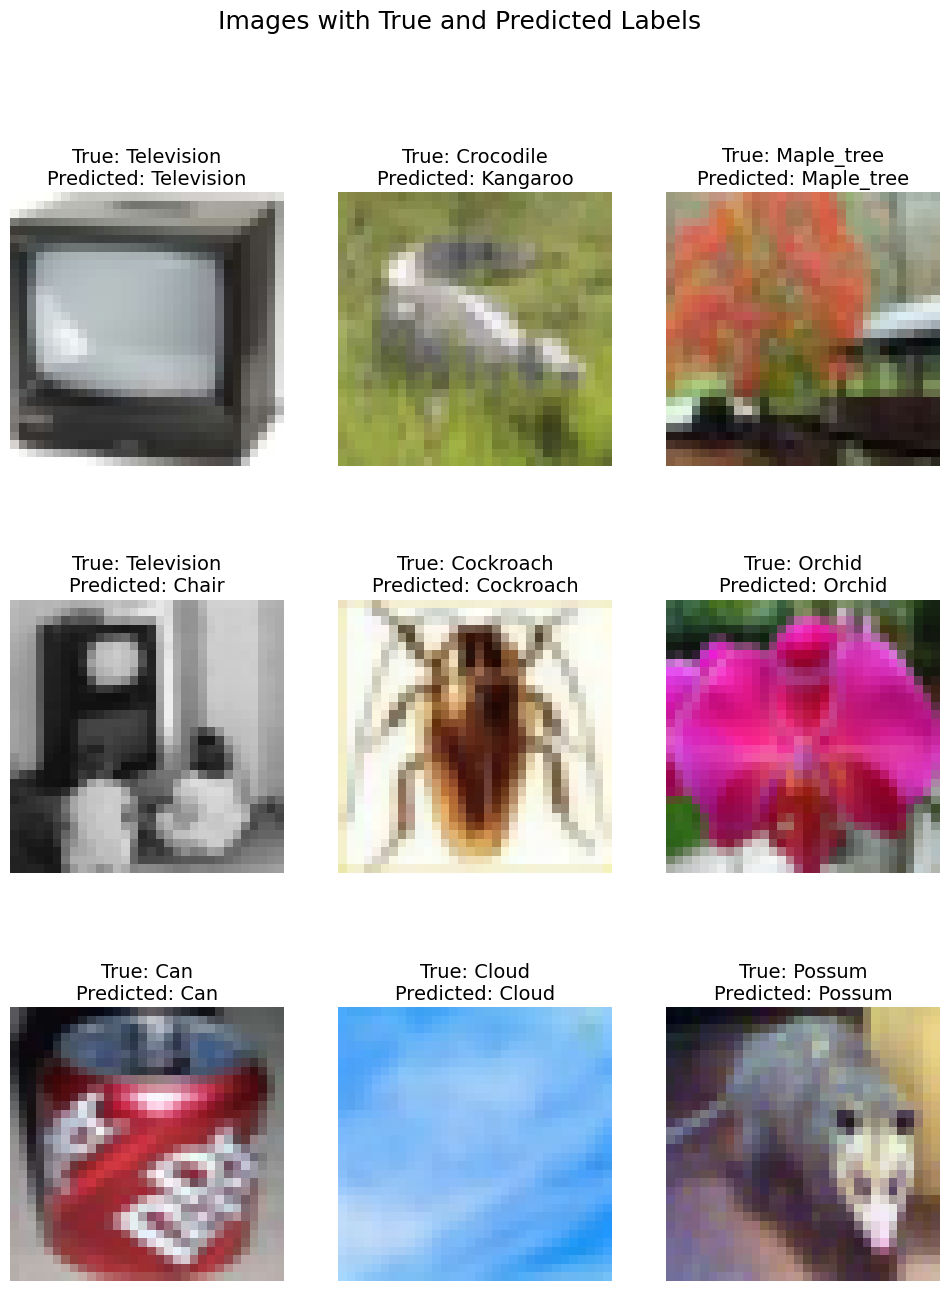

In [67]:
rcParams['figure.figsize'] = 12,15

num_row = 3
num_col = 3

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()